In [2]:
%load_ext autoreload
%autoreload 2

# Libraries imports

In [3]:
import joblib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np 
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import sys
import time
from xgboost.sklearn import XGBClassifier
import warnings


sys.path.append('../')

from utils import SCORING
from transforms import encode_df, remove_stopwords, stem

In [4]:
model_version = "0.1.0"

# Data Exploration

In [5]:
df = pd.read_csv("../data/raw/dataset.csv")
df.head()

,label,text
0,ham,"Subject: flow volumes at oxy gladewater , mete..."
1,ham,Subject: 02 / 00 natural gas nomination\r\nenr...
2,spam,Subject: re : official us goverment program\r\...
3,ham,"Subject: hpl nom for march 17 , 2001\r\n( see ..."
4,ham,"Subject: hpl noms for april 17 , 2001\r\n( see..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4136 non-null   object
 1   text    4136 non-null   object
dtypes: object(2)
memory usage: 64.8+ KB


In [7]:
df.shape

(4136, 2)

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df.shape

(4019, 2)

In [10]:
print(pd.DataFrame(df.isnull().sum()))

       0
label  0
text   0


In [11]:
df['label'].value_counts()

label
ham     2854
spam    1165
Name: count, dtype: int64

<Axes: >

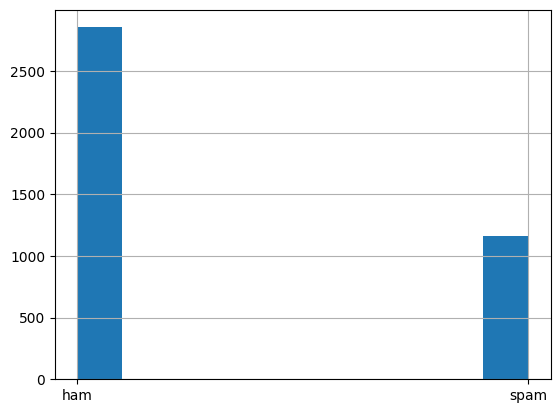

In [12]:
df['label'].hist()

# Feature Engineering

In [13]:
#Adding a column of numbers of charachters,words and sentences in each sms
df["nb_characters"] = df["text"].apply(len)
df["nb_words"] = df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
df["nb_sentence"] = df.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
nb_characters,4019.0,1075.078875,1586.045076,11.0,254.0,558.0,1260.5,32258.0
nb_words,4019.0,235.617069,352.762632,2.0,54.0,125.0,289.5,8863.0
nb_sentence,4019.0,13.551132,30.180947,1.0,4.0,7.0,15.0,1204.0


<Figure size 1200x800 with 0 Axes>

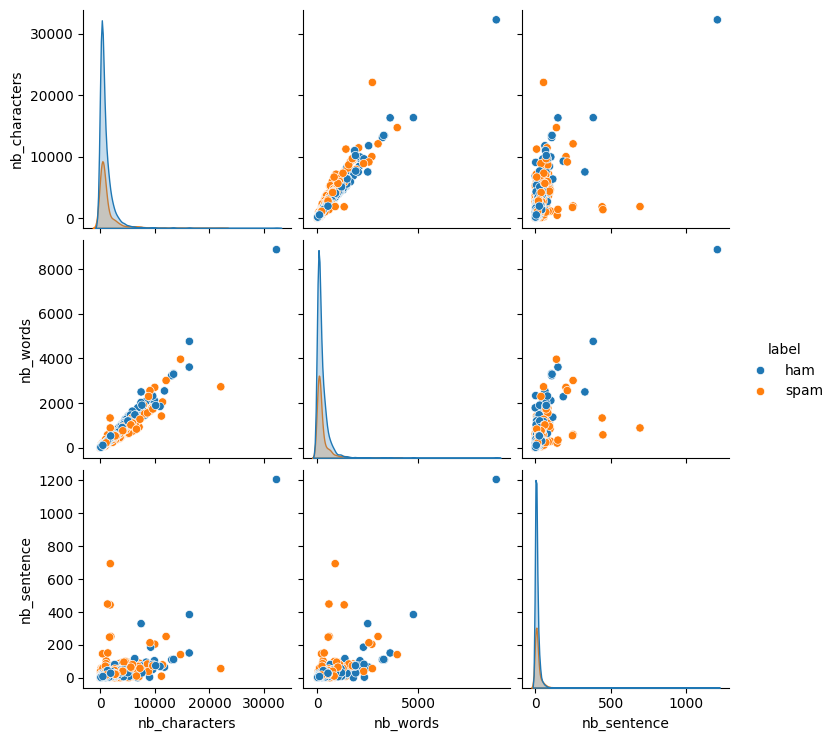

In [14]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label")
plt.show(fg)

Note: From the pair plot, we can see a few outliers all in the class `ham`. 

Let's filter out the outliers by capping one of the features just created (indicate the same thing ie. the length of SMS).

In [15]:
df.shape

(4019, 5)

In [16]:
#Dropping the outliers. 
df_1 = df[(df["nb_characters"]<1000)]
df_1.shape

(2758, 5)

In [17]:
outliers_sms = df.shape[0]-df_1.shape[0]

In [18]:
df_1_ham = df_1[df_1.label=='ham']
df_1_spam = df_1[df_1.label=='spam']

outliers_sms_ham = (df_1_ham.shape[0] / df.shape[0])*100
outliers_sms_spam = (df_1_spam.shape[0] / df.shape[0])*100

In [19]:
print(f'We have removed {outliers_sms} outliers (SMS containing more than 1000 characters)')

We have removed 1261 outliers (SMS containing more than 1000 characters)


In [20]:
print(f'We have removed {outliers_sms_ham :.2f}% ham outliers (SMS containing more than 1000 characters)')

We have removed 48.67% ham outliers (SMS containing more than 1000 characters)


In [21]:
print(f'We have removed {outliers_sms_spam :.2f}% spam outliers (SMS containing more than 1000 characters)')

We have removed 19.96% spam outliers (SMS containing more than 1000 characters)


<Figure size 1200x800 with 0 Axes>

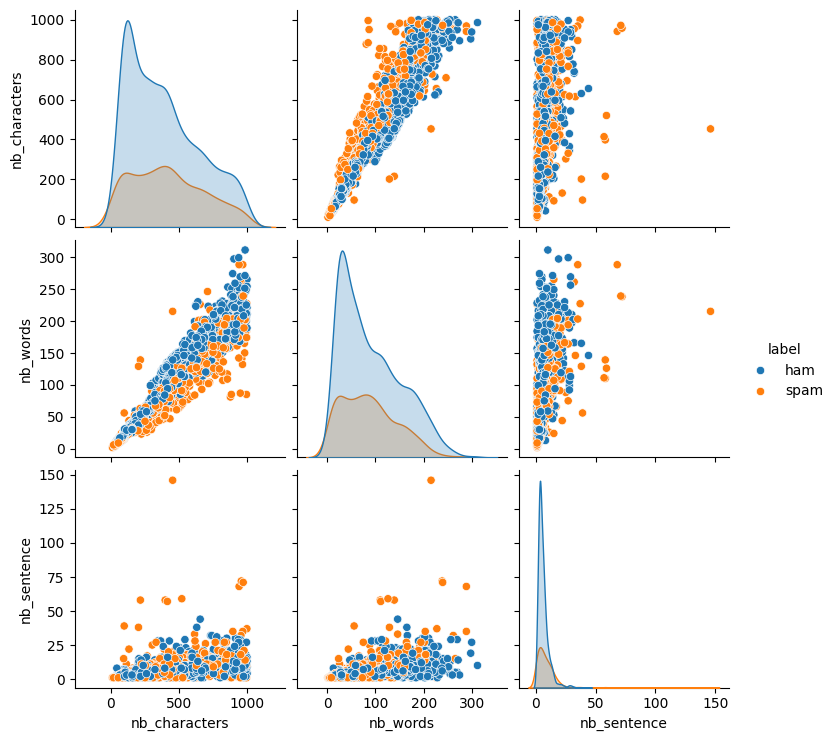

In [22]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df_1, hue="label")
plt.show(fg)

# Cleaning text

1. Remove punctuation and numbers.
2. Convert all the characters into lowercase.

In [23]:
separator = "-" * 100

In [24]:
# Lets have a look at a sample of texts before cleaning
print("\033[91;1;4;7m\033[5m The First 5 Texts\033[0m", *df["text"][:5], sep = f"\n{separator}\n")

 The First 5 Texts
----------------------------------------------------------------------------------------------------
Subject: flow volumes at oxy gladewater , meter 98926
bob ,
i have a volume of about 713 / day at the above referenced meter . i don ' t
have a deal in the system to allocate to for october ( flow began on 10 / 11 ) .
this is hitting my exception report . please advise .
mary
----------------------------------------------------------------------------------------------------
Subject: 02 / 00 natural gas nomination
enron methanol nominates the following requirements for the methanol plant
for february 2000 :
33 , 000 mmbtu per day
egpfc nominates the following requirements for the mtbe plant at morgan ' s
point for february 2000 :
10 , 000 mmbtu per day
----------------------------------------------------------------------------------------------------
Subject: re : official us goverment program
casualty gantletmustache alphonse archaicterrify
dapple dentoncology expen

In [25]:
# Defining a function to clean up the text
def clean(text):
    sms = re.sub('[^a-zA-Z]', ' ', text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df_1["clean_text"] = df_1["text"].apply(clean)
#Lets have a look at a sample of texts after cleaning
print("\033[91;1;4;7m\033[5m The First 5 Texts after cleaning\033[0m", *df_1["clean_text"][:5], sep = f"\n{separator}\n")

 The First 5 Texts after cleaning
----------------------------------------------------------------------------------------------------
subject flow volumes at oxy gladewater meter bob i have a volume of about day at the above referenced meter i don t have a deal in the system to allocate to for october flow began on this is hitting my exception report please advise mary
----------------------------------------------------------------------------------------------------
subject natural gas nomination enron methanol nominates the following requirements for the methanol plant for february mmbtu per day egpfc nominates the following requirements for the mtbe plant at morgan s point for february mmbtu per day
----------------------------------------------------------------------------------------------------
subject re official us goverment program casualty gantletmustache alphonse archaicterrify dapple dentoncology expend lausannewhit tenable innermostkinglet erupt espritawaken attentive i

/tmp/ipykernel_14/595425893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["clean_text"] = df_1["text"].apply(clean)


# Tokenization

`Tokenization` is breaking chunk of words into smaller units called tokens. 
- We need to split `clean_text` column into words at this step.

In [26]:
df_1["tokenize_text"]=df_1.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)

print("\033[91;1;4;7m\033[5m The First 5 Texts after Tokenizing\033[0m", *df_1["tokenize_text"][:5], sep = f"\n{separator}\n")

 The First 5 Texts after Tokenizing
----------------------------------------------------------------------------------------------------
['subject', 'flow', 'volumes', 'at', 'oxy', 'gladewater', 'meter', 'bob', 'i', 'have', 'a', 'volume', 'of', 'about', 'day', 'at', 'the', 'above', 'referenced', 'meter', 'i', 'don', 't', 'have', 'a', 'deal', 'in', 'the', 'system', 'to', 'allocate', 'to', 'for', 'october', 'flow', 'began', 'on', 'this', 'is', 'hitting', 'my', 'exception', 'report', 'please', 'advise', 'mary']
----------------------------------------------------------------------------------------------------
['subject', 'natural', 'gas', 'nomination', 'enron', 'methanol', 'nominates', 'the', 'following', 'requirements', 'for', 'the', 'methanol', 'plant', 'for', 'february', 'mmbtu', 'per', 'day', 'egpfc', 'nominates', 'the', 'following', 'requirements', 'for', 'the', 'mtbe', 'plant', 'at', 'morgan', 's', 'point', 'for', 'february', 'mmbtu', 'per', 'day']
---------------------------------

/tmp/ipykernel_14/1049720049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["tokenize_text"]=df_1.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)


`Stopwords` are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [27]:
df_1["nostopword_text"] = df_1["tokenize_text"].apply(remove_stopwords)
print("\033[91;1;4;7m\033[5m The First 5 Texts after removing the stopwords:\033[0m",*df_1["nostopword_text"][:5], sep = f"\n{separator}\n")

 The First 5 Texts after removing the stopwords:
----------------------------------------------------------------------------------------------------
['subject', 'flow', 'volumes', 'oxy', 'gladewater', 'meter', 'bob', 'volume', 'day', 'referenced', 'meter', 'deal', 'system', 'allocate', 'october', 'flow', 'began', 'hitting', 'exception', 'report', 'please', 'advise', 'mary']
----------------------------------------------------------------------------------------------------
['subject', 'natural', 'gas', 'nomination', 'enron', 'methanol', 'nominates', 'following', 'requirements', 'methanol', 'plant', 'february', 'mmbtu', 'per', 'day', 'egpfc', 'nominates', 'following', 'requirements', 'mtbe', 'plant', 'morgan', 'point', 'february', 'mmbtu', 'per', 'day']
----------------------------------------------------------------------------------------------------
['subject', 'official', 'us', 'goverment', 'program', 'casualty', 'gantletmustache', 'alphonse', 'archaicterrify', 'dapple', 'dentoncol

/tmp/ipykernel_14/669592046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["nostopword_text"] = df_1["tokenize_text"].apply(remove_stopwords)


# Stemming

`Stemming` is the process of getting the root form of a word. 
- Stem or root is the part to which inflectional affixes are added.
- The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

`Lemmatization` also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English. But Lemmatization uses a corpus to attain a lemma, making it slower than stemming for production, we will choose stemming.

In [28]:
df_1['stemmed_text'] = df_1["nostopword_text"].apply(stem)
print("\033[91;1;4;7m\033[5m The First 5 Texts after after lemitization:\033[0m",*df_1["nostopword_text"][:5], sep = f"\n{separator}\n")

 The First 5 Texts after after lemitization:
----------------------------------------------------------------------------------------------------
['subject', 'flow', 'volumes', 'oxy', 'gladewater', 'meter', 'bob', 'volume', 'day', 'referenced', 'meter', 'deal', 'system', 'allocate', 'october', 'flow', 'began', 'hitting', 'exception', 'report', 'please', 'advise', 'mary']
----------------------------------------------------------------------------------------------------
['subject', 'natural', 'gas', 'nomination', 'enron', 'methanol', 'nominates', 'following', 'requirements', 'methanol', 'plant', 'february', 'mmbtu', 'per', 'day', 'egpfc', 'nominates', 'following', 'requirements', 'mtbe', 'plant', 'morgan', 'point', 'february', 'mmbtu', 'per', 'day']
----------------------------------------------------------------------------------------------------
['subject', 'official', 'us', 'goverment', 'program', 'casualty', 'gantletmustache', 'alphonse', 'archaicterrify', 'dapple', 'dentoncology'

/tmp/ipykernel_14/3665679009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['stemmed_text'] = df_1["nostopword_text"].apply(stem)


# Vectorize

`TF-IDF` in NLP stands for Term Frequency – Inverse document frequency. 

In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as `Word embedding` or `Word vectorization`.

- Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents)
- Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t))

I will be using `TfidfVectorizer()` to vectorize the preprocessed data.

`Steps in the Vectorizing`:

- Creating a corpus of stemmed text
- Converting the corpus in vector form
- Label Encoding the classes in label

In [29]:
#Creating a corpus of text feature to encode further into vectorized form
df_1["preprocessed_text"] = [' '.join(row) for row in df_1["stemmed_text"]]

print("\033[91;1;4;7m\033[5m The First 5 lines in corpus :\033[0m",*df_1["preprocessed_text"][:5], sep = f"\n{separator}\n")

 The First 5 lines in corpus :
----------------------------------------------------------------------------------------------------
subject flow volum oxi gladewat meter bob volum day referenc meter deal system alloc octob flow began hit except report pleas advis mari
----------------------------------------------------------------------------------------------------
subject natur ga nomin enron methanol nomin follow requir methanol plant februari mmbtu per day egpfc nomin follow requir mtbe plant morgan point februari mmbtu per day
----------------------------------------------------------------------------------------------------
subject offici us gover program casualti gantletmustach alphons archaicterrifi dappl dentoncolog expend lausannewhit tenabl innermostkinglet erupt espritawaken attent idioticosmium warwick electrophoruschilean anchorit butternutcultiv
----------------------------------------------------------------------------------------------------
subject hpl nom march se

/tmp/ipykernel_14/1523085945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["preprocessed_text"] = [' '.join(row) for row in df_1["stemmed_text"]]


In [30]:
label_encoder = LabelEncoder()
df_1["target"] = label_encoder.fit_transform(df_1["label"])
y = df_1["target"] 

# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size=0.2, random_state=42, shuffle=True, stratify=df_1["target"] )

encoder = TfidfVectorizer()
X_train, y_train, encoder = encode_df(X_train, encoder)
X_test, y_test, encoder = encode_df(X_test, encoder)

/tmp/ipykernel_14/3342354936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["target"] = label_encoder.fit_transform(df_1["label"])


In [45]:
encoder_path = (
                        f"../data/models/TfidfVectorizer_version_{model_version}.joblib"
                    )
joblib.dump(encoder, encoder_path)

['./models/TfidfVectorizer_version_0.1.0.joblib']

In [44]:
ls

llm.ipynb  models/  xgboost.ipynb


# Model

**Steps involved in the Model Building**

- Setting up features and target as `X` and `y`
- Splitting the training/testing sets
- Build a pipeline of model for four different classifiers.
    - `Naïve Bayes`
    - `RandomForestClassifier`
    - `KNeighborsClassifier`
    - `Support Vector Machines`
- Fit all the models on training data
- Get the cross-validation on the training set for all the models for accuracy

In [31]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC(),
               XGBClassifier()]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours", 3: "SVC", 4: "XGB"}

In [32]:
# Evaluate model with cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scores_dict = {}
for i, model in enumerate(classifiers):
    cv = cross_validate(
                                model,
                                X_train,
                                y_train,
                                scoring=list(SCORING.keys()),
                                cv=stratified_kfold,
                                n_jobs=-1,
                                error_score="raise",
                            )
    model_name = pipe_dict[i]
    scores = pd.DataFrame(
                    index=[model_name],
                    columns=list(SCORING.keys()) + ["fit_time"],
                )
    scores.loc[model_name, 'fit_time'] = cv["fit_time"].mean()
    for score_name, score_fn in SCORING.items():
        scores.loc[model_name, score_name] = cv[f"test_{score_name}"].mean()
        scores_dict[model_name] = scores

In [33]:
pd.concat(list(scores_dict.values()))

,f1,precision,recall,accuracy,fit_time
NaiveBayes,0.825115,0.997849,0.703553,0.913417,0.535307
RandomForest,0.94938,0.947298,0.951618,0.970532,4.837542
KNeighbours,0.91923,0.98572,0.861151,0.956029,0.080409
SVC,0.967206,0.947865,0.987524,0.980505,24.420576
XGB,0.920567,0.901351,0.940751,0.952857,5.736019


# Model Evaluation

**Testing the models on test set**

- Accuracy Report
- Confusion Matrix

In [34]:
# Create list of metrics
scores = pd.DataFrame(
    index=list(pipe_dict.values()),
    columns=list(SCORING.keys()) + ["training_time", "inference_time"],
)

for i, clf in enumerate(classifiers):
    model_name = pipe_dict[i]
    start = time.time()
    clf.fit(X_train, y_train)
    model_path = (
                        f"../data/models/{model_name}_version_{model_version}.joblib"
                    )
    joblib.dump(clf, model_path)
    end = time.time()
    scores.loc[model_name, "training_time"] = end - start

    start = time.time()
    y_pred = clf.predict(X_test)
    end = time.time()
    scores.loc[model_name, "inference_time"] = end - start

    for score_name, score_fn in SCORING.items():
        scores.loc[model_name, score_name] = score_fn(y_pred, y_test)

In [35]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
scores.apply(pd.to_numeric).style.background_gradient(cmap=cmap2)

,f1,precision,recall,accuracy,training_time,inference_time
NaiveBayes,0.860140,0.763975,0.984000,0.927536,0.098706,0.039763
RandomForest,0.950920,0.962733,0.939394,0.971014,6.468397,0.032015
KNeighbours,0.931148,0.881988,0.986111,0.961957,0.829141,0.354774
SVC,0.972308,0.981366,0.963415,0.983696,17.655122,9.627693
XGB,0.917431,0.931677,0.903614,0.951087,3.726815,0.009949


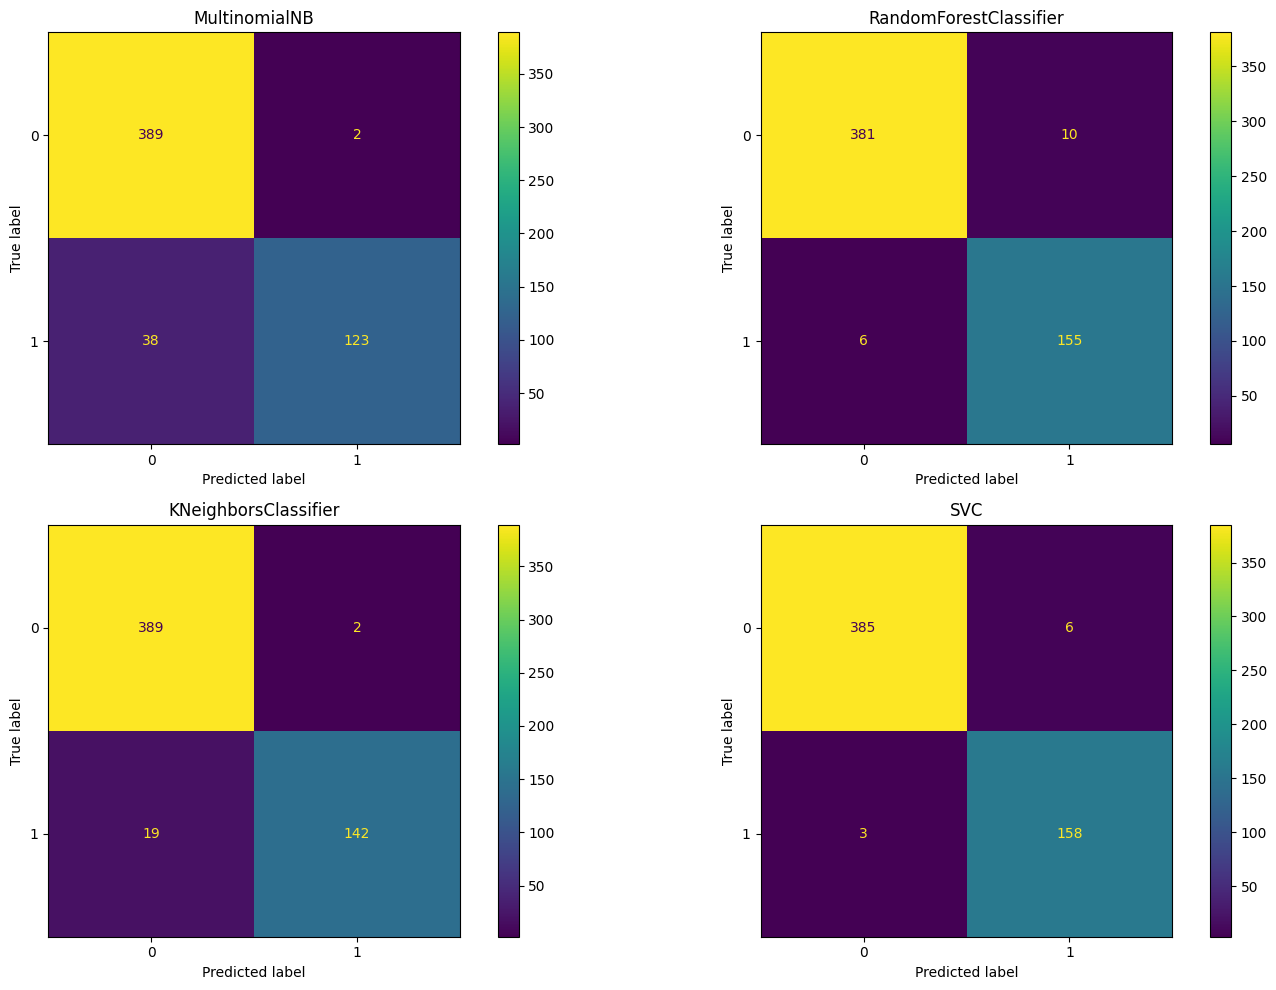

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for clf, ax in zip(classifiers, axes.flatten()):
    y_pred_test = clf.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=clf.classes_)
    disp.plot(ax=ax)
    ax.title.set_text(type(clf).__name__)
    
plt.tight_layout()  
plt.show()

In [38]:
sample = input('Enter a message:')
res = encoder.transform([sample]).toarray()
clf = joblib.load("../data/models/SVC_version_0.1.0.joblib")
print(label_encoder.inverse_transform(clf.predict(res)))

Enter a message: f


['spam']
